# Import lib

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from yellowbrick.classifier.rocauc import roc_auc

#!pip install scikit-optimize # needed to import skopt
from skopt import BayesSearchCV

from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [ ]:
data = pd.read_csv('Consumption.csv', index_col=0)

In [ ]:
data.head()

,Class,H00:00,H00:15,H00:30,H00:45,H01:00,H01:15,H01:30,H01:45,H02:00,...,H21:30,H21:45,H22:00,H22:15,H22:30,H22:45,H23:00,H23:15,H23:30,H23:45
0,0,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,...,5.99020,2.91270,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611,-0.18611
1,0,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700,...,0.19151,6.47670,1.64510,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700,-0.17700
2,0,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,...,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353,-0.21353
3,0,-0.17147,-0.17147,-0.17147,-0.17147,-0.17147,-0.17147,-0.17147,-0.17147,-0.17147,...,0.16088,0.18043,0.16088,7.35540,1.17750,-0.17147,-0.17147,-0.17147,-0.17147,-0.17147
4,0,-0.16927,-0.16927,-0.16927,-0.16927,-0.16927,-0.16927,-0.16927,-0.16927,-0.16927,...,0.19095,6.07440,0.17093,0.19095,0.19095,7.39520,0.85133,-0.16927,-0.16927,-0.16927


In [ ]:
data['Class'].value_counts()

,count
Class,
4,2406
1,2231
3,1474
2,851
6,728
0,727
5,509


In [ ]:
cls = [str(v) for v in sorted(data['Class'].unique())]
cls

['0', '1', '2', '3', '4', '5', '6']

In [ ]:
for c in data.columns:
    if data[c].isna().sum() > 0:
      print(c, data[c].isna().sum())

# Partition data

In [ ]:
X = data.iloc[:,1:]
y = data.loc[:,'Class']

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=42,stratify=y) #

In [ ]:
# Standardize
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

# Training

In [ ]:
param = {'hidden_layer_sizes': [10,50,100, 200, 300], 'activation':['relu', 'identity', 'logistic'], 'alpha':[0.0001, 0.001, 0.01],
         'momentum': [0.95,0.90, 0.85, 0.80], 'learning_rate_init':[0.001, 0.01,0.1], 'n_iter_no_change':[10,20,30,40,50], 'learning_rate':['constant', 'invscaling','adaptive']}
# identity - keeps output value same as input f(x) = x
# for prevent overfit after no loss improvement
mlp = MLPClassifier(max_iter=10000, early_stopping=True, random_state=0)
mlp_search = BayesSearchCV(mlp, param, n_iter = 15, cv=5, n_jobs=-1, refit=True,random_state=0)
mlp_search.fit(X_train_s, y_train)



BayesSearchCV(cv=5,
              estimator=MLPClassifier(early_stopping=True, max_iter=10000,
                                      random_state=0),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'activation': ['relu', 'identity', 'logistic'],
                             'alpha': [0.0001, 0.001, 0.01],
                             'hidden_layer_sizes': [10, 50, 100, 200, 300],
                             'learning_rate': ['constant', 'invscaling',
                                               'adaptive'],
                             'learning_rate_init': [0.001, 0.01, 0.1],
                             'momentum': [0.95, 0.9, 0.85, 0.8],
                             'n_iter_no_change': [10, 20, 30, 40, 50]})

In [ ]:
show_html(pd.DataFrame(mlp_search.cv_results_).loc[:, ['params', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
6,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.8, 'n_iter_no_change': 30}",0.710870,1
11,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 100, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 30}",0.710870,1
1,"{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 300, 'learning_rate': 'invscaling', 'learning_rate_init': 0.001, 'momentum': 0.95, 'n_iter_no_change': 40}",0.710702,3
5,"{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': 200, 'learning_rate': 'invscaling', 'learning_rate_init': 0.01, 'momentum': 0.9, 'n_iter_no_change': 50}",0.710535,4
4,"{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': 200, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'momentum': 0.9, 'n_iter_no_change': 10}",0.708194,5


## Classif. report

In [ ]:
print(classification_report(mlp_search.predict(X_test_s), y_test, target_names=cls))

              precision    recall  f1-score   support

           0       0.59      0.62      0.61       226
           1       0.90      0.87      0.89       762
           2       0.63      0.58      0.61       306
           3       0.67      0.58      0.62       566
           4       0.77      0.82      0.80       749
           5       0.24      0.34      0.28       117
           6       0.50      0.55      0.53       220

    accuracy                           0.71      2946
   macro avg       0.62      0.62      0.62      2946
weighted avg       0.72      0.71      0.71      2946



## Confusion matrix

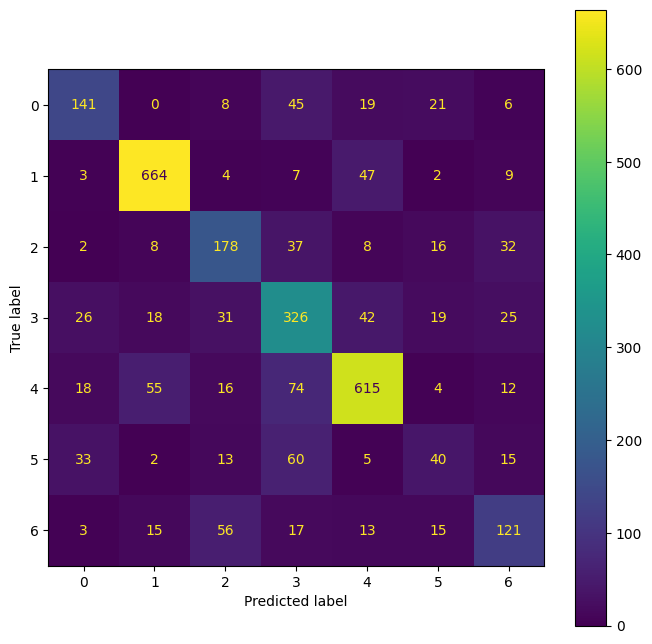

In [ ]:
plt.figure(figsize=(8,8))
ConfusionMatrixDisplay.from_estimator(mlp_search,X_test_s, y_test, display_labels=cls, ax=plt.subplot())

## Roc curve

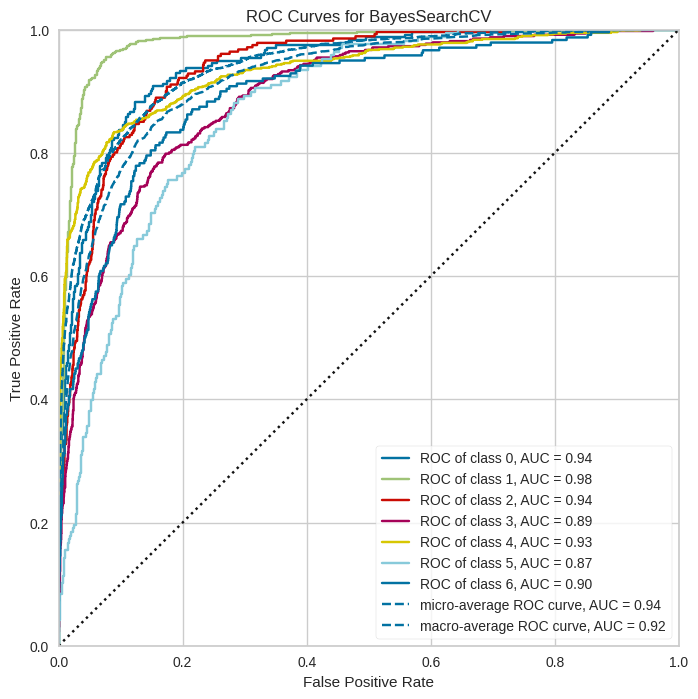

In [ ]:
plt.figure(figsize=(8,8))
roc_auc(mlp_search, X_train_s, y_train, X_test_s, y_test, classes=cls);